# Loading libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import*
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, GBTClassifier, MultilayerPerceptronClassifier

# Creating SparkSession

In [2]:
spark = SparkSession.builder.appName('BankMarketing').getOrCreate()

In [243]:
pwd

'/home/.engr-ece/vfi245'

In [7]:
cd /data/nazmul

/data/nazmul


In [245]:
ls

 Acc-adaptive-MAML.pdf                Loss-overall-MAML.pdf
 Acc-MAML-adaptive.pdf                MAML-adaptive.pdf
 Acc-MAML-combined.pdf                MAML-project.ipynb
 Acc-MAML.pdf                         Music/
 Acc-overall-MAML.pdf                 nohup.out
 amazon-user-review-pyspark.ipynb     Pascal_VOC_object_detection_RCNN.ipynb
 anaconda3/                           Pictures/
 Anaconda3-2021.05-Linux-x86_64.sh*   Public/
'Bank Marketing Campaign.ipynb'       Templates/
 data/                                tmux-3.2a/
 Desktop/                             tmux-3.2a.tar.gz
 Documents/                           Untitled1.ipynb
 Downloads/                           Untitled2.ipynb
 HAM10k-VirtualMachine.ipynb          Untitled.ipynb
 Loss-adaptive-MAML.pdf               Videos/
 Loss-MAML.pdf


In [20]:
!unzip bank+marketing.zip -d bank-marketing

Archive:  bank+marketing.zip
 extracting: bank-marketing/bank.zip  
 extracting: bank-marketing/bank-additional.zip  


In [246]:
ls

 Acc-adaptive-MAML.pdf                Loss-overall-MAML.pdf
 Acc-MAML-adaptive.pdf                MAML-adaptive.pdf
 Acc-MAML-combined.pdf                MAML-project.ipynb
 Acc-MAML.pdf                         Music/
 Acc-overall-MAML.pdf                 nohup.out
 amazon-user-review-pyspark.ipynb     Pascal_VOC_object_detection_RCNN.ipynb
 anaconda3/                           Pictures/
 Anaconda3-2021.05-Linux-x86_64.sh*   Public/
'Bank Marketing Campaign.ipynb'       Templates/
 data/                                tmux-3.2a/
 Desktop/                             tmux-3.2a.tar.gz
 Documents/                           Untitled1.ipynb
 Downloads/                           Untitled2.ipynb
 HAM10k-VirtualMachine.ipynb          Untitled.ipynb
 Loss-adaptive-MAML.pdf               Videos/
 Loss-MAML.pdf


In [28]:
!unzip bank.zip -d bank-dataset

Archive:  bank.zip
  inflating: bank-dataset/bank-full.csv  
  inflating: bank-dataset/bank-names.txt  
  inflating: bank-dataset/bank.csv   


# Loading data using Spark

In [3]:
df = spark.read.option("header", "true").option("delimiter", ";").csv('/data/nazmul/bank-dataset/bank-full.csv')

In [4]:
df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|      1|     no|  no|unknown|  5|  may

# Checking data types

In [5]:
df.printSchema()

root
 |-- age: string (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: string (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- campaign: string (nullable = true)
 |-- pdays: string (nullable = true)
 |-- previous: string (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [6]:
df.dtypes

[('age', 'string'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'string'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'string'),
 ('month', 'string'),
 ('duration', 'string'),
 ('campaign', 'string'),
 ('pdays', 'string'),
 ('previous', 'string'),
 ('poutcome', 'string'),
 ('y', 'string')]

# Working on Spark SQL 

In [7]:
df.filter((df['age'] == '')| df['age'].isNull() | isnan(df['age'])).count()

0

In [8]:
df.select([count(when((col(c) == '') | col(c).isNull() | isnan(c),c)).alias(c) for c in df.columns]).show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|  0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+



In [9]:
df.describe()

DataFrame[summary: string, age: string, job: string, marital: string, education: string, default: string, balance: string, housing: string, loan: string, contact: string, day: string, month: string, duration: string, campaign: string, pdays: string, previous: string, poutcome: string, y: string]

In [10]:
df.count()

45211

In [11]:
df.groupby(df['job']).count().show()

+-------------+-----+
|          job|count|
+-------------+-----+
|   management| 9458|
|      retired| 2264|
|      unknown|  288|
|self-employed| 1579|
|      student|  938|
|  blue-collar| 9732|
| entrepreneur| 1487|
|       admin.| 5171|
|   technician| 7597|
|     services| 4154|
|    housemaid| 1240|
|   unemployed| 1303|
+-------------+-----+



In [12]:
df.groupby(df['marital']).count().show()

+--------+-----+
| marital|count|
+--------+-----+
|divorced| 5207|
| married|27214|
|  single|12790|
+--------+-----+



In [13]:
df.groupby(df['education']).count().show()

+---------+-----+
|education|count|
+---------+-----+
|  unknown| 1857|
| tertiary|13301|
|secondary|23202|
|  primary| 6851|
+---------+-----+



In [14]:
df.groupby(df['default']).count().show()

+-------+-----+
|default|count|
+-------+-----+
|     no|44396|
|    yes|  815|
+-------+-----+



In [15]:
df.groupby(df['balance']).count().show()

+-------+-----+
|balance|count|
+-------+-----+
|     -4|   15|
|   -212|    8|
|    675|    9|
|    296|   31|
|    829|    8|
|  56831|    1|
|   -650|    2|
|   2294|    5|
|   7252|    2|
|   1572|    6|
|   2904|    6|
|  10436|    1|
|  -1655|    1|
|   -757|    1|
|   1090|    8|
|  45141|    1|
|   6613|    2|
|   7711|    2|
|    -86|    3|
|   -874|    2|
+-------+-----+
only showing top 20 rows



In [16]:
df.groupby(df['housing']).count().show()

+-------+-----+
|housing|count|
+-------+-----+
|     no|20081|
|    yes|25130|
+-------+-----+



In [17]:
df.groupby(df['loan']).count().show()

+----+-----+
|loan|count|
+----+-----+
|  no|37967|
| yes| 7244|
+----+-----+



# Converting Spark data frame to pandas data frame

In [18]:
df.describe().toPandas()

,summary,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
1,mean,40.93621021432837,None,None,None,None,1362.2720576850766,None,None,None,15.80641879188693,None,258.1630797814691,2.763840658246887,40.19782796222158,0.5803233726305546,None,None
2,stddev,10.618762040975401,None,None,None,None,3044.7658291685243,None,None,None,8.322476153044589,None,257.5278122651712,3.0980208832791813,100.12874599059818,2.3034410449312164,None,None
3,min,18,admin.,divorced,primary,no,-1,no,no,cellular,1,apr,0,1,-1,0,failure,no
4,max,95,unknown,single,unknown,yes,9997,yes,yes,unknown,9,sep,999,9,99,9,unknown,yes


In [19]:
target_variable_name = 'y'

In [20]:
df.groupby(df[target_variable_name]).count().show()

+---+-----+
|  y|count|
+---+-----+
| no|39922|
|yes| 5289|
+---+-----+



In [21]:
df.groupby(df[target_variable_name]).agg({'balance': 'avg', 'age': 'avg'}).show()

+---+------------------+------------------+
|  y|      avg(balance)|          avg(age)|
+---+------------------+------------------+
| no|1303.7149691899203| 40.83898602274435|
|yes|1804.2679145396105|41.670069956513515|
+---+------------------+------------------+



# Cardinality check all columns

In [240]:
def cardinality_calculation(df, cut_off=1):
    cardinality = df.select(*[approxCountDistinct(c).alias(c) for c in
    df.columns])
    final_cardinality_df = cardinality.toPandas().transpose()
    final_cardinality_df.reset_index(inplace=True)
    final_cardinality_df.rename(columns={0:'Cardinality'}, inplace=True)
    vars_selected = final_cardinality_df[final_cardinality_df['Cardinality'] <= cut_off]['index']
    return final_cardinality_df, vars_selected


In [6]:
cardinality_df, cardinality_vars_selected = cardinality_calculation(df)

/data/nazmul/anaconda3/lib/python3.8/site-packages/pyspark/sql/functions.py:3796: FutureWarning: Deprecated in 2.1, use approx_count_distinct instead.
  warnings.warn("Deprecated in 2.1, use approx_count_distinct instead.", FutureWarning)


In [7]:
cardinality_df

,index,Cardinality
0,age,80
1,job,11
2,marital,3
3,education,4
4,default,2
5,balance,6546
6,housing,2
7,loan,2
8,contact,3
9,day,32


In [9]:
cardinality_vars_selected

Series([], Name: index, dtype: object)

# Missing value check all columns

In [8]:
def missing_value_calculation(df, missing_value_percentage=0.8):
    missing_counts = [
        count(when(col(c).isNull() | isnan(c), c)).alias(c)
        for c in df.columns
    ]
    missing = df.select(*missing_counts)
    df_length = df.count()
    final_missing = missing.toPandas().transpose()
    final_missing.reset_index(inplace = True)
    final_missing.rename(columns={0:'missing_count'}, inplace = True)
    final_missing['missing_percentage'] = final_missing['missing_count']/df_length
    
    missing_var_selected = final_missing[final_missing['missing_percentage'] > missing_value_percentage]['index']
    return final_missing, missing_var_selected

In [9]:
missing_value, var_selected = missing_value_calculation(df)

In [10]:
missing_value

,index,missing_count,missing_percentage
0,age,0,0.0
1,job,0,0.0
2,marital,0,0.0
3,education,0,0.0
4,default,0,0.0
5,balance,0,0.0
6,housing,0,0.0
7,loan,0,0.0
8,contact,0,0.0
9,day,0,0.0


In [13]:
var_selected

Series([], Name: index, dtype: object)

# Feature data type selection

In [11]:
def variable_type(df):
    var_list = df.dtypes
    char_list = []
    num_list = []
    
    for var in var_list:
        if var[1] != ('string'):
            num_list.append(var[0])
        else:
            char_list.append(var[0])
    return char_list, num_list
            

In [12]:
char_list, num_list = variable_type(df)

In [13]:
char_list

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y']

In [17]:
num_list

[]

# StringIndexer for making numerical data

In [14]:
def category_to_index(df, char_vars):
    char_df = df.select(char_vars)
    indexers = [StringIndexer(inputCol=c, outputCol=c+"_index",
    handleInvalid="keep") for c in char_df.columns]
    pipeline = Pipeline(stages=indexers)
    char_labels = pipeline.fit(char_df)
    df = char_labels.transform(df)
    return df, char_labels
   

In [15]:
df, char_labels = category_to_index(df, char_list)

In [16]:
char_labels

PipelineModel_6f214effb26c

In [17]:
df.dtypes

[('age', 'string'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'string'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'string'),
 ('month', 'string'),
 ('duration', 'string'),
 ('campaign', 'string'),
 ('pdays', 'string'),
 ('previous', 'string'),
 ('poutcome', 'string'),
 ('y', 'string'),
 ('age_index', 'double'),
 ('job_index', 'double'),
 ('marital_index', 'double'),
 ('education_index', 'double'),
 ('default_index', 'double'),
 ('balance_index', 'double'),
 ('housing_index', 'double'),
 ('loan_index', 'double'),
 ('contact_index', 'double'),
 ('day_index', 'double'),
 ('month_index', 'double'),
 ('duration_index', 'double'),
 ('campaign_index', 'double'),
 ('pdays_index', 'double'),
 ('previous_index', 'double'),
 ('poutcome_index', 'double'),
 ('y_index', 'double')]

In [18]:
df = df.select([c for c in df.columns if c not in char_list])

In [19]:
df.show()

+---------+---------+-------------+---------------+-------------+-------------+-------------+----------+-------------+---------+-----------+--------------+--------------+-----------+--------------+--------------+-------+
|age_index|job_index|marital_index|education_index|default_index|balance_index|housing_index|loan_index|contact_index|day_index|month_index|duration_index|campaign_index|pdays_index|previous_index|poutcome_index|y_index|
+---------+---------+-------------+---------------+-------------+-------------+-------------+----------+-------------+---------+-----------+--------------+--------------+-----------+--------------+--------------+-------+
|     33.0|      1.0|          0.0|            1.0|          0.0|       2117.0|          0.0|       0.0|          1.0|      5.0|        0.0|         243.0|           0.0|        0.0|           0.0|           0.0|    0.0|
|     17.0|      2.0|          1.0|            0.0|          0.0|         83.0|          0.0|       0.0|          1.

In [20]:
def rename_columns(df, char_vars):
    mapping = dict(zip([i + '_index' for i in char_vars], char_vars))
    df = df.select([col(c).alias(mapping.get(c, c)) for c in df.columns])
    return df

In [24]:
df = rename_columns(df, char_list)

In [25]:
df.show()

+----+----+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| age| job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+----+----+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|33.0| 1.0|    0.0|      1.0|    0.0| 2117.0|    0.0| 0.0|    1.0|5.0|  0.0|   243.0|     0.0|  0.0|     0.0|     0.0|0.0|
|17.0| 2.0|    1.0|      0.0|    0.0|   83.0|    0.0| 0.0|    1.0|5.0|  0.0|    40.0|     0.0|  0.0|     0.0|     0.0|0.0|
| 2.0| 7.0|    0.0|      0.0|    0.0|    2.0|    0.0| 1.0|    1.0|5.0|  0.0|    37.0|     0.0|  0.0|     0.0|     0.0|0.0|
|18.0| 0.0|    0.0|      3.0|    0.0| 1359.0|    0.0| 0.0|    1.0|5.0|  0.0|    15.0|     0.0|  0.0|     0.0|     0.0|0.0|
| 2.0|11.0|    1.0|      3.0|    0.0|    1.0|    1.0| 0.0|    1.0|5.0|  0.0|   123.0|     0.0|  0.0|     0.0|     0.0|0.0|
| 4.0| 1.0|    0

In [23]:
from pyspark.ml.feature import VectorAssembler
def assemble_vectors(df, features_list, target_variable_name):
    stages = []
    assembler = VectorAssembler(inputCols=features_list,
    outputCol='features')
    stages = [assembler]
    selectedCols = [target_variable_name, 'features'] + features_list
    pipeline = Pipeline(stages=stages)
    assembleModel = pipeline.fit(df)
    df = assembleModel.transform(df).select(selectedCols)
    return df

In [26]:
target_variable_name = 'y'
features_list = df.columns
features_list.remove(target_variable_name)
#df = assemble_vectors(df, features_list, target_variable_name)

In [28]:
df.show()

+----+----+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| age| job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+----+----+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|33.0| 1.0|    0.0|      1.0|    0.0| 2117.0|    0.0| 0.0|    1.0|5.0|  0.0|   243.0|     0.0|  0.0|     0.0|     0.0|0.0|
|17.0| 2.0|    1.0|      0.0|    0.0|   83.0|    0.0| 0.0|    1.0|5.0|  0.0|    40.0|     0.0|  0.0|     0.0|     0.0|0.0|
| 2.0| 7.0|    0.0|      0.0|    0.0|    2.0|    0.0| 1.0|    1.0|5.0|  0.0|    37.0|     0.0|  0.0|     0.0|     0.0|0.0|
|18.0| 0.0|    0.0|      3.0|    0.0| 1359.0|    0.0| 0.0|    1.0|5.0|  0.0|    15.0|     0.0|  0.0|     0.0|     0.0|0.0|
| 2.0|11.0|    1.0|      3.0|    0.0|    1.0|    1.0| 0.0|    1.0|5.0|  0.0|   123.0|     0.0|  0.0|     0.0|     0.0|0.0|
| 4.0| 1.0|    0

# Vector Assemble and Feature Scaling

In [27]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

def assemble_vectors_with_scaling(df, features_list, target_variable_name):
    stages = []
    
    assembler = VectorAssembler(inputCols=features_list, outputCol='raw_features')
    stages.append(assembler)
    
    scaler = StandardScaler(inputCol='raw_features', outputCol='scaled_features', withMean=True, withStd=True)
    stages.append(scaler)
    
    final_assembler = VectorAssembler(inputCols=['scaled_features'], outputCol='features')
    stages.append(final_assembler)
    
    selectedCols = [target_variable_name, 'features'] + features_list
    
    pipeline = Pipeline(stages=stages)
    
    pipelineModel = pipeline.fit(df)
    
    df_transformed = pipelineModel.transform(df).select(selectedCols)
    
    return df_transformed

scaled_df = assemble_vectors_with_scaling(df, features_list, target_variable_name)


In [28]:
scaled_df.show()

+---+--------------------+----+----+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+
|  y|            features| age| job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|
+---+--------------------+----+----+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+
|0.0|[1.48681013473743...|33.0| 1.0|    0.0|      1.0|    0.0| 2117.0|    0.0| 0.0|    1.0|5.0|  0.0|   243.0|     0.0|  0.0|     0.0|     0.0|
|0.0|[0.14449397633147...|17.0| 2.0|    1.0|      0.0|    0.0|   83.0|    0.0| 0.0|    1.0|5.0|  0.0|    40.0|     0.0|  0.0|     0.0|     0.0|
|0.0|[-1.1139274221741...| 2.0| 7.0|    0.0|      0.0|    0.0|    2.0|    0.0| 1.0|    1.0|5.0|  0.0|    37.0|     0.0|  0.0|     0.0|     0.0|
|0.0|[0.22838873623184...|18.0| 0.0|    0.0|      3.0|    0.0| 1359.0|    0.0| 0.0|    1.0|5.0|  0.0|    15.0|     0.0|  0.0|     0.0|  

# PCA analysis

In [29]:
from pyspark.ml.feature import PCA

def apply_pca(df, num_components, input_col, output_col):
    pca = PCA(k=num_components, inputCol=input_col, outputCol=output_col)
    pca_model = pca.fit(df)
    df_transformed = pca_model.transform(df)
    return df_transformed,pca_model


num_components = 3  

pca_df, pca_model = apply_pca(scaled_df, num_components, input_col='features', output_col='pca_features')


In [30]:
pca_model.pc.toArray()

array([[-0.04286982,  0.4920219 , -0.22323716],
       [-0.05501484,  0.42718685,  0.13297609],
       [-0.03421558,  0.01230686,  0.37440105],
       [ 0.00985805,  0.22433871, -0.47416155],
       [ 0.04938132, -0.03086653,  0.19678395],
       [ 0.01182259,  0.13971403, -0.20758647],
       [-0.06360871,  0.54533245,  0.22486653],
       [ 0.05037557, -0.14712573,  0.2533394 ],
       [ 0.21729808,  0.03198733, -0.50783508],
       [-0.0089565 ,  0.11904237, -0.02275009],
       [-0.30944881,  0.35030048,  0.20832696],
       [-0.02026495,  0.01312412, -0.03288015],
       [ 0.12058269, -0.02093828, -0.13193068],
       [-0.51115744, -0.13046894, -0.10932632],
       [-0.50070019, -0.14995977, -0.16246118],
       [-0.56099456, -0.08610978, -0.11076326]])

In [31]:
pca_df.select('pca_features').show()

+--------------------+
|        pca_features|
+--------------------+
|[1.03298083637395...|
|[1.01098145946516...|
|[1.14817948430724...|
|[1.14376130201403...|
|[0.77788055768080...|
|[1.14269816862764...|
|[1.16763995641598...|
|[1.22812958903618...|
|[0.95601469051056...|
|[1.01226693880603...|
|[0.95527743707480...|
|[0.99718870386952...|
|[0.99042819455073...|
|[1.0375340554644,...|
|[0.97725625447924...|
|[0.97604404820348...|
|[1.03915951837652...|
|[1.06835713458695...|
|[0.95073596726132...|
|[1.06338711293655...|
+--------------------+
only showing top 20 rows



In [32]:
pca_model.explainedVariance

DenseVector([0.1425, 0.0984, 0.0734])

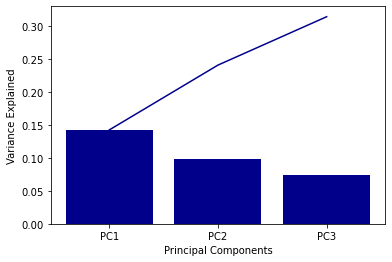

In [33]:
import matplotlib.pyplot as plt
import numpy as np
x = []
for i in range(0, len(pca_model.explainedVariance)):
    x.append('PC' + str(i + 1))
y = np.array(pca_model.explainedVariance)
z = np.cumsum(pca_model.explainedVariance)
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.bar(x, y, color = 'darkblue')
plt.plot(x, z, color = 'darkblue')

In [34]:
x

['PC1', 'PC2', 'PC3']

# Model Based Feature Selection (Random Forest)

In [37]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'y', maxBins = 8000)
rf_model = rf.fit(scaled_df)

In [38]:
rf_model.featureImportances

SparseVector(16, {0: 0.0525, 1: 0.0016, 2: 0.0019, 3: 0.0008, 5: 0.0028, 6: 0.0455, 7: 0.0034, 8: 0.0203, 9: 0.0081, 10: 0.1505, 11: 0.3988, 12: 0.0029, 13: 0.0466, 14: 0.0316, 15: 0.2328})

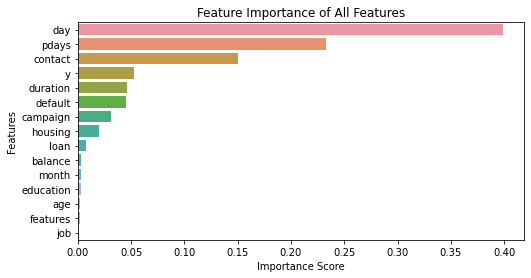

In [194]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

feature_importances = rf_model.featureImportances

feature_importance_dict = {idx: value for idx, value in zip(feature_importances.indices, feature_importances.values)}

sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

feature_names = scaled_df.columns

plt.figure(figsize=(8, 4))
sns.barplot(x=list(sorted_feature_importance.values()), y=[feature_names[i] for i in sorted_feature_importance.keys()])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance of All Features')
plt.show()


In [195]:
from pyspark.sql.functions import col
feature_names.remove('y')
feature_names.remove('features')
threshold = 0.0
selected_features = [feature_names[i] for i, importance in sorted_feature_importance.items() if importance >= threshold]
selected_cols =  ['y'] + selected_features

selected_df = scaled_df.select(selected_cols)
selected_df.show()


+---+--------+--------+-----+----+-----+-------+--------+-------+---+----+--------+-------+-------+----+---------+
|  y|duration|poutcome|month| age|pdays|housing|previous|contact|day|loan|campaign|balance|marital| job|education|
+---+--------+--------+-----+----+-----+-------+--------+-------+---+----+--------+-------+-------+----+---------+
|0.0|   243.0|     0.0|  0.0|33.0|  0.0|    0.0|     0.0|    1.0|5.0| 0.0|     0.0| 2117.0|    0.0| 1.0|      1.0|
|0.0|    40.0|     0.0|  0.0|17.0|  0.0|    0.0|     0.0|    1.0|5.0| 0.0|     0.0|   83.0|    1.0| 2.0|      0.0|
|0.0|    37.0|     0.0|  0.0| 2.0|  0.0|    0.0|     0.0|    1.0|5.0| 1.0|     0.0|    2.0|    0.0| 7.0|      0.0|
|0.0|    15.0|     0.0|  0.0|18.0|  0.0|    0.0|     0.0|    1.0|5.0| 0.0|     0.0| 1359.0|    0.0| 0.0|      3.0|
|0.0|   123.0|     0.0|  0.0| 2.0|  0.0|    1.0|     0.0|    1.0|5.0| 0.0|     0.0|    1.0|    1.0|11.0|      3.0|
|0.0|     8.0|     0.0|  0.0| 4.0|  0.0|    0.0|     0.0|    1.0|5.0| 0.0|     0

# Train-Test spliting

In [79]:
def train_test_split(df):
    feature_columns = df.columns[1:]  # Assuming the first column is 'y'

    # Assemble the features into a single vector column
    assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
    assembled_df = assembler.transform(df)

    # Split the data into training and testing sets (70% train, 30% test)
    train_data, test_data = assembled_df.randomSplit([0.7, 0.3], seed=123)
    
    return train_data, test_data

In [197]:
feature_columns

['duration',
 'poutcome',
 'month',
 'age',
 'pdays',
 'housing',
 'previous',
 'contact',
 'day',
 'loan',
 'campaign',
 'balance',
 'marital',
 'job',
 'education']

# Logistic Regression

In [73]:
lr = LogisticRegression(featuresCol='features', labelCol='y')

lr_model4 = lr.fit(train_data)

# Make predictions on the test data
prediction_lr4 = lr_model4.transform(test_data)

# Decision Tree Classifier

In [116]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'y', maxBins = 8000)
dt_model1 = dt.fit(train_data)
prediction_dt1 = dt_model1.transform(test_data)

# Random Forest Classifier

In [165]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'y', maxBins = 8000)
rf_model3 = rf.fit(train_data)
prediction_rf3 = rf_model3.transform(test_data)

# Gradient Boosting Classifier

In [184]:
gb = GBTClassifier(featuresCol = 'features', labelCol = 'y', maxBins = 8000)
gb_model = gb.fit(train_data)
prediction_gb4 = gb_model.transform(test_data)

# Function for ROC calculation

In [239]:
def roc_calculation(model_prediction):
    extract_prob_udf = udf(lambda raw_pred: float(raw_pred[1]), DoubleType())

    model_prediction = model_prediction.withColumn('probability', extract_prob_udf('rawPrediction'))

    model_predictions_pd = model_prediction.select('y', 'probability').toPandas()
    
    fpr, tpr, thresholds = roc_curve(model_predictions_pd['y'], model_predictions_pd['probability'])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# ROC curve for Logistic Regression

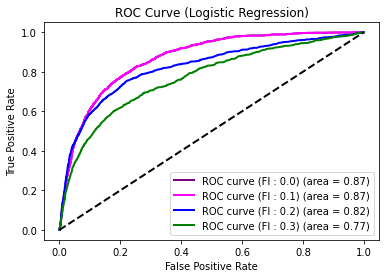

In [191]:
fpr_lr1, tpr_lr1, roc_auc_lr1 = roc_calculation(prediction_lr1) 
fpr_lr2, tpr_lr2, roc_auc_lr2 = roc_calculation(prediction_lr2) 
fpr_lr3, tpr_lr3, roc_auc_lr3 = roc_calculation(prediction_lr3)
fpr_lr4, tpr_lr4, roc_auc_lr4 = roc_calculation(prediction_lr4) 

plt.figure(figsize=(6, 4))
plt.plot(fpr_lr1, tpr_lr1, color='purple', lw=2, label=f'ROC curve (FI : 0.0) (area = {roc_auc_lr1:.2f})')
plt.plot(fpr_lr2, tpr_lr2, color='magenta', lw=2, label=f'ROC curve (FI : 0.1) (area = {roc_auc_lr2:.2f})')
plt.plot(fpr_lr3, tpr_lr3, color='blue', lw=2, label=f'ROC curve (FI : 0.2) (area = {roc_auc_lr3:.2f})')
plt.plot(fpr_lr4, tpr_lr4, color='green', lw=2, label=f'ROC curve (FI : 0.3) (area = {roc_auc_lr4:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression)')
plt.legend(loc='lower right')
plt.show()

# ROC curve for Decision Tree

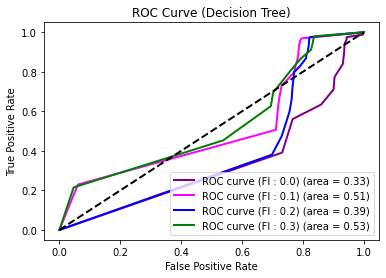

In [190]:
fpr_dt1, tpr_dt1, roc_auc_dt1 = roc_calculation(prediction_dt1) 
fpr_dt2, tpr_dt2, roc_auc_dt2 = roc_calculation(prediction_dt2) 
fpr_dt3, tpr_dt3, roc_auc_dt3 = roc_calculation(prediction_dt3)
fpr_dt4, tpr_dt4, roc_auc_dt4 = roc_calculation(prediction_dt4)

plt.figure(figsize=(6, 4))
plt.plot(fpr_dt1, tpr_dt1, color='purple', lw=2, label=f'ROC curve (FI : 0.0) (area = {roc_auc_dt1:.2f})')
plt.plot(fpr_dt2, tpr_dt2, color='magenta', lw=2, label=f'ROC curve (FI : 0.1) (area = {roc_auc_dt2:.2f})')
plt.plot(fpr_dt3, tpr_dt3, color='blue', lw=2, label=f'ROC curve (FI : 0.2) (area = {roc_auc_dt3:.2f})')
plt.plot(fpr_dt4, tpr_dt4, color='green', lw=2, label=f'ROC curve (FI : 0.3) (area = {roc_auc_dt4:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Decision Tree)')
plt.legend(loc='lower right')
plt.show()

# ROC curve for Random Forest

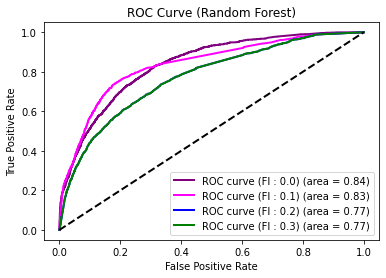

In [189]:
fpr_rf1, tpr_rf1, roc_auc_rf1 = roc_calculation(prediction_rf1) 
fpr_rf2, tpr_rf2, roc_auc_rf2 = roc_calculation(prediction_rf2) 
fpr_rf3, tpr_rf3, roc_auc_rf3 = roc_calculation(prediction_rf3)
fpr_rf4, tpr_rf4, roc_auc_rf4 = roc_calculation(prediction_rf4) 

plt.figure(figsize=(6, 4))
plt.plot(fpr_rf1, tpr_rf1, color='purple', lw=2, label=f'ROC curve (FI : 0.0) (area = {roc_auc_rf1:.2f})')
plt.plot(fpr_rf2, tpr_rf2, color='magenta', lw=2, label=f'ROC curve (FI : 0.1) (area = {roc_auc_rf2:.2f})')
plt.plot(fpr_rf3, tpr_rf3, color='blue', lw=2, label=f'ROC curve (FI : 0.2) (area = {roc_auc_rf3:.2f})')
plt.plot(fpr_rf4, tpr_rf4, color='green', lw=2, label=f'ROC curve (FI : 0.3) (area = {roc_auc_rf4:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend(loc='lower right')
plt.show()

# ROC curve for Gradient Boosting

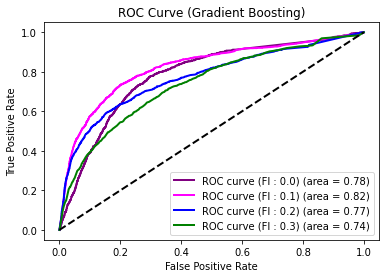

In [188]:
fpr_gb1, tpr_gb1, roc_auc_gb1 = roc_calculation(prediction_gb1) 
fpr_gb2, tpr_gb2, roc_auc_gb2 = roc_calculation(prediction_gb2) 
fpr_gb3, tpr_gb3, roc_auc_gb3 = roc_calculation(prediction_gb3)
fpr_gb4, tpr_gb4, roc_auc_gb4 = roc_calculation(prediction_gb4) 

plt.figure(figsize=(6, 4))
plt.plot(fpr_gb1, tpr_gb1, color='purple', lw=2, label=f'ROC curve (FI : 0.0) (area = {roc_auc_gb1:.2f})')
plt.plot(fpr_gb2, tpr_gb2, color='magenta', lw=2, label=f'ROC curve (FI : 0.1) (area = {roc_auc_gb2:.2f})')
plt.plot(fpr_gb3, tpr_gb3, color='blue', lw=2, label=f'ROC curve (FI : 0.2) (area = {roc_auc_gb3:.2f})')
plt.plot(fpr_gb4, tpr_gb4, color='green', lw=2, label=f'ROC curve (FI : 0.3) (area = {roc_auc_gb4:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Gradient Boosting)')
plt.legend(loc='lower right')
plt.show()

In [109]:
def confusion_mat(model_prediction):
    model_predictions_pd = model_prediction.select('y', 'prediction').toPandas()
    _cm = confusion_matrix(model_predictions_pd['y'], model_predictions_pd['prediction'])
    return _cm  

# Confusion Matrix for Logistic Regression

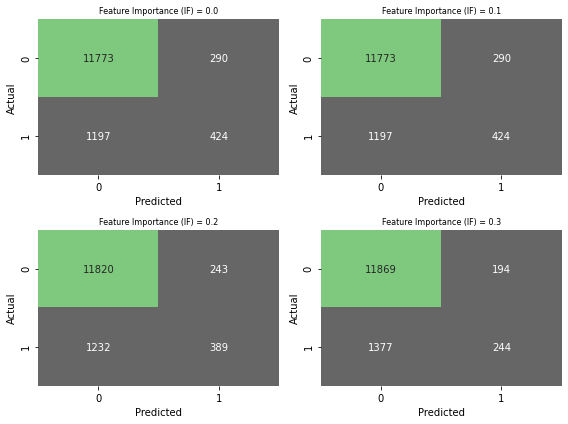

In [159]:
cm_lr1 = confusion_mat(prediction_lr1)
cm_lr2 = confusion_mat(prediction_lr2)
cm_lr3 = confusion_mat(prediction_lr3)
cm_lr4 = confusion_mat(prediction_lr4)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

sns.heatmap(cm_lr1, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 0], cbar = False)
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('Feature Importance (IF) = 0.0', fontsize = 8)

sns.heatmap(cm_lr2, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 1], cbar = False)
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_title('Feature Importance (IF) = 0.1', fontsize = 8)

sns.heatmap(cm_lr3, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 0], cbar = False)
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Feature Importance (IF) = 0.2', fontsize = 8)

sns.heatmap(cm_lr4, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 1], cbar = False)
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title('Feature Importance (IF) = 0.3', fontsize = 8)

plt.tight_layout()
plt.show()


# Confusion Matrix for Decision Tree

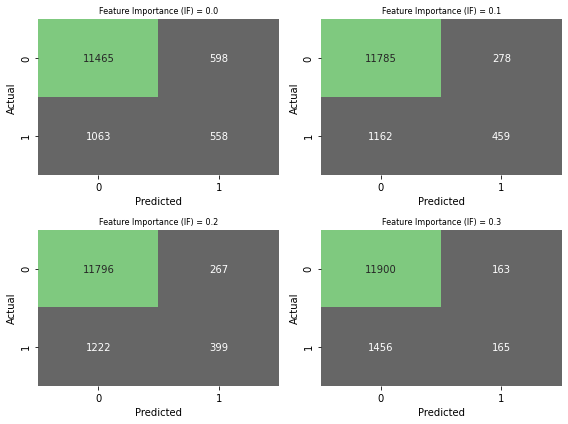

In [156]:
cm_dt1 = confusion_mat(prediction_dt1)
cm_dt2 = confusion_mat(prediction_dt2)
cm_dt3 = confusion_mat(prediction_dt3)
cm_dt4 = confusion_mat(prediction_dt4)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

sns.heatmap(cm_dt1, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 0], cbar = False)
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('Feature Importance (IF) = 0.0', fontsize = 8)

sns.heatmap(cm_dt2, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 1], cbar = False)
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_title('Feature Importance (IF) = 0.1', fontsize = 8)

sns.heatmap(cm_dt3, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 0], cbar = False)
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Feature Importance (IF) = 0.2', fontsize = 8)

sns.heatmap(cm_dt4, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 1], cbar = False)
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title('Feature Importance (IF) = 0.3', fontsize = 8)

plt.tight_layout()
plt.show()


# Confusion Matrix for Random Forest

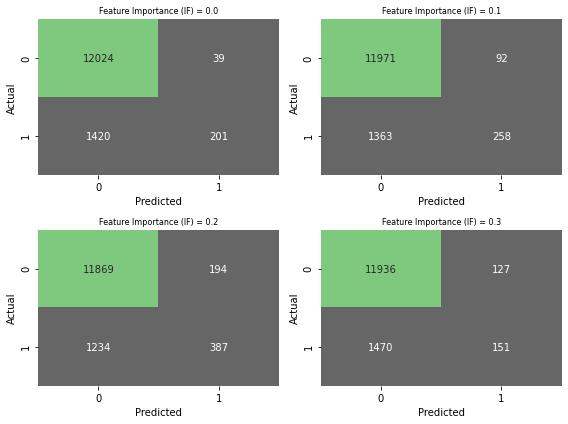

In [157]:
cm_rf1 = confusion_mat(prediction_rf1)
cm_rf2 = confusion_mat(prediction_rf2)
cm_rf3 = confusion_mat(prediction_rf3)
cm_rf4 = confusion_mat(prediction_rf4)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

sns.heatmap(cm_rf1, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 0], cbar = False)
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('Feature Importance (IF) = 0.0', fontsize = 8)

sns.heatmap(cm_rf2, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 1], cbar = False)
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_title('Feature Importance (IF) = 0.1', fontsize = 8)

sns.heatmap(cm_rf3, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 0], cbar = False)
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Feature Importance (IF) = 0.2', fontsize = 8)

sns.heatmap(cm_rf4, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 1], cbar = False)
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title('Feature Importance (IF) = 0.3', fontsize = 8)

plt.tight_layout()
plt.show()


# Confusion Matrix for Gradient Boosting

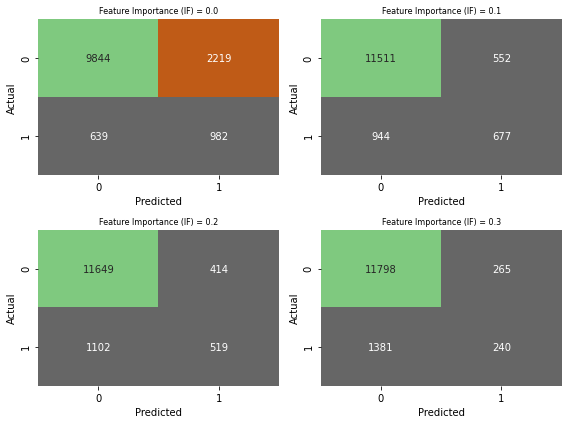

In [192]:
cm_gb1 = confusion_mat(prediction_gb1)
cm_gb2 = confusion_mat(prediction_gb2)
cm_gb3 = confusion_mat(prediction_gb3)
cm_gb4 = confusion_mat(prediction_gb4)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

sns.heatmap(cm_gb1, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 0], cbar = False)
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('Feature Importance (IF) = 0.0', fontsize = 8)

sns.heatmap(cm_gb2, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 1], cbar = False)
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_title('Feature Importance (IF) = 0.1', fontsize = 8)

sns.heatmap(cm_gb3, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 0], cbar = False)
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Feature Importance (IF) = 0.2', fontsize = 8)

sns.heatmap(cm_gb4, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 1], cbar = False)
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title('Feature Importance (IF) = 0.3', fontsize = 8)

plt.tight_layout()
plt.show()


# Model based feature selection (Decision Tree)

In [237]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'y')
dt_model = dt.fit(scaled_df)
dt_model.featureImportances

SparseVector(16, {0: 0.018, 2: 0.0008, 5: 0.0032, 6: 0.0067, 8: 0.0273, 10: 0.1219, 11: 0.5061, 13: 0.0104, 15: 0.3055})

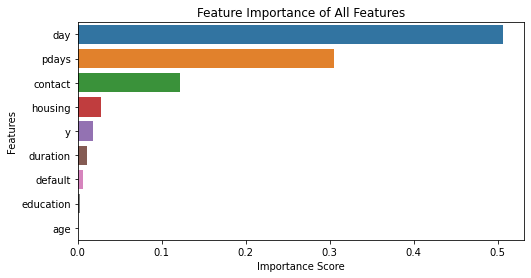

In [238]:
feature_importances_dt = dt_model.featureImportances

feature_importance_dict = {idx: value for idx, value in zip(feature_importances_dt.indices, feature_importances_dt.values)}

sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))
feature_names = scaled_df.columns

plt.figure(figsize=(8, 4))
sns.barplot(x=list(sorted_feature_importance.values()), y=[feature_names[i] for i in sorted_feature_importance.keys()])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance of All Features')
plt.show()

# Model based feature selection (Logistic Regression)

In [35]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'y')
lr_model = lr.fit(scaled_df)
lr_model.coefficientMatrix

DenseMatrix(3, 16, [0.0341, -0.0931, 0.0729, -0.0471, 0.0018, 0.0097, 0.1411, -0.1402, ..., 0.4772, -0.5389, -0.3852, -1.8582, 0.6767, 0.1641, 0.1293, -0.4044], 1)

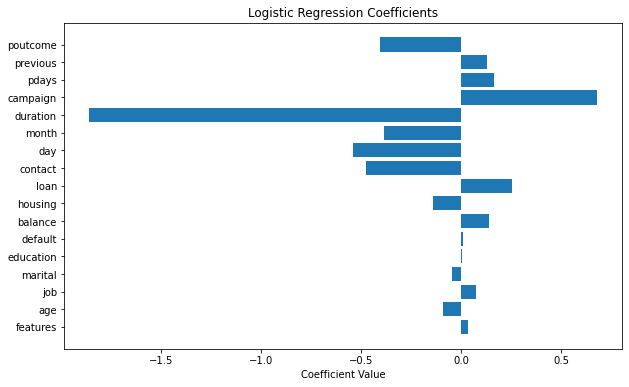

In [37]:
import matplotlib.pyplot as plt

# Coefficients from lr_model.coefficientMatrix
coefficients = [0.0341, -0.0931, 0.0729, -0.0471, 0.0018, 0.0097, 0.1411, -0.1402,
                0.2546, -0.4772, -0.5389, -0.3852, -1.8582, 0.6767, 0.1641, 0.1293, -0.4044]

# Feature names (assuming you have access to them)
feature_names = scaled_df.columns
feature_names.remove('y')

# Create a bar plot for coefficients
plt.figure(figsize=(10, 6))
plt.barh(range(len(coefficients)), coefficients, align='center')
plt.xlabel('Coefficient Value')
plt.yticks(range(len(coefficients)), feature_names)
plt.title('Logistic Regression Coefficients')
plt.show()


In [229]:
df = spark.createDataFrame(list(feature_coefficients.items()), ['key', 'value'])

# Calculate absolute values using PySpark's abs function
abs_df = df.withColumn('abs_value', pyspark_abs(df['value']))

sorted_abs_df_desc = abs_df.orderBy('abs_value', ascending=False)


top_n = 16  # Change this value to select a different number of top features
selected_features = sorted_abs_df_desc.limit(top_n).select('key','abs_value')

#top_feature_names = [row['key'] for row in selected_features.collect()]

# Print the top feature names
#print("Top feature names based on absolute coefficients:", top_feature_names)

# Print the top features
print("Top features based on absolute coefficients:", selected_features.show())

+--------+---------+
|     key|abs_value|
+--------+---------+
|duration|   1.8582|
|campaign|   0.6767|
|     day|   0.5389|
| contact|   0.4772|
|poutcome|   0.4044|
|   month|   0.3852|
|    loan|   0.2546|
|   pdays|   0.1641|
| balance|   0.1411|
| housing|   0.1402|
|previous|   0.1293|
|     age|   0.0931|
|     job|   0.0729|
| marital|   0.0471|
|features|   0.0341|
| default|   0.0097|
+--------+---------+

Top features based on absolute coefficients: None


In [230]:
selected_keys = selected_features.select('key')

# Collect the selected key names into a list
key_names = [row['key'] for row in selected_keys.collect()]

# Print the list of key names
print("Key names based on absolute coefficients:", key_names)

Key names based on absolute coefficients: ['duration', 'campaign', 'day', 'contact', 'poutcome', 'month', 'loan', 'pdays', 'balance', 'housing', 'previous', 'age', 'job', 'marital', 'features', 'default']


In [231]:
feature_names = scaled_df.columns
feature_names.remove('y')
feature_names.remove('features')
selected_features = [col for col in feature_names if col in key_names]

# Add 'y' back to the selected columns
selected_cols = ['y'] + selected_features

# Select the desired columns from scaled_df
selected_df = scaled_df.select(selected_cols)

# Show the selected DataFrame
selected_df.show()

+---+----+----+-------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+
|  y| age| job|marital|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|
+---+----+----+-------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+
|0.0|33.0| 1.0|    0.0|    0.0| 2117.0|    0.0| 0.0|    1.0|5.0|  0.0|   243.0|     0.0|  0.0|     0.0|     0.0|
|0.0|17.0| 2.0|    1.0|    0.0|   83.0|    0.0| 0.0|    1.0|5.0|  0.0|    40.0|     0.0|  0.0|     0.0|     0.0|
|0.0| 2.0| 7.0|    0.0|    0.0|    2.0|    0.0| 1.0|    1.0|5.0|  0.0|    37.0|     0.0|  0.0|     0.0|     0.0|
|0.0|18.0| 0.0|    0.0|    0.0| 1359.0|    0.0| 0.0|    1.0|5.0|  0.0|    15.0|     0.0|  0.0|     0.0|     0.0|
|0.0| 2.0|11.0|    1.0|    0.0|    1.0|    1.0| 0.0|    1.0|5.0|  0.0|   123.0|     0.0|  0.0|     0.0|     0.0|
|0.0| 4.0| 1.0|    0.0|    0.0|  204.0|    0.0| 0.0|    1.0|5.0|  0.0|     8.0|     0.0|  0.0|  

In [232]:
train_data, test_data = train_test_split(selected_df)

# Logistic Regression (LR  feature selection)

In [118]:
lr = LogisticRegression(featuresCol='features', labelCol='y')

# Train the model
lr_model = lr.fit(train_data)

# Make predictions on the test data
prediction_lr6 = lr_model.transform(test_data)

# ROC curve for Logistic Regression

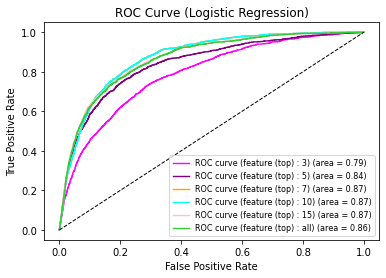

In [203]:
fpr_lr1, tpr_lr1, roc_auc_lr1 = roc_calculation(prediction_lr1) 
fpr_lr2, tpr_lr2, roc_auc_lr2 = roc_calculation(prediction_lr2) 
fpr_lr3, tpr_lr3, roc_auc_lr3 = roc_calculation(prediction_lr3)
fpr_lr4, tpr_lr4, roc_auc_lr4 = roc_calculation(prediction_lr4)
fpr_lr5, tpr_lr5, roc_auc_lr5 = roc_calculation(prediction_lr5)
fpr_lr6, tpr_lr6, roc_auc_lr6 = roc_calculation(prediction_lr6)

plt.figure(figsize=(6, 4))
plt.plot(fpr_lr2, tpr_lr2, color='magenta', lw=1.4, label=f'ROC curve (feature (top) : 3) (area = {roc_auc_lr2:.2f})')
plt.plot(fpr_lr1, tpr_lr1, color='purple', lw=1.4, label=f'ROC curve (feature (top) : 5) (area = {roc_auc_lr1:.2f})')
plt.plot(fpr_lr3, tpr_lr3, color='orange', lw=1.4, label=f'ROC curve (feature (top) : 7) (area = {roc_auc_lr3:.2f})')
plt.plot(fpr_lr4, tpr_lr4, color='cyan', lw=1.4, label=f'ROC curve (feature (top) : 10) (area = {roc_auc_lr4:.2f})')
plt.plot(fpr_lr5, tpr_lr5, color='pink', lw=1.4, label=f'ROC curve (feature (top) : 15) (area = {roc_auc_lr5:.2f})')
plt.plot(fpr_lr6, tpr_lr6, color='limegreen', lw=1.4, label=f'ROC curve (feature (top) : all) (area = {roc_auc_lr6:.2f})')

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression)')
plt.legend(loc='lower right', fontsize = 8)
plt.show()

# Confusion Matrix for Logistic Regression

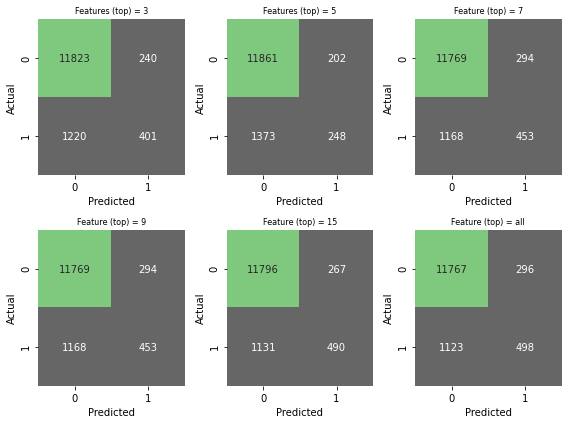

In [127]:
cm_lr1 = confusion_mat(prediction_lr1)
cm_lr2 = confusion_mat(prediction_lr2)
cm_lr3 = confusion_mat(prediction_lr3)
cm_lr4 = confusion_mat(prediction_lr4)
cm_lr5 = confusion_mat(prediction_lr5)
cm_lr6 = confusion_mat(prediction_lr6)

fig, axes = plt.subplots(2, 3, figsize=(8, 6))

sns.heatmap(cm_lr1, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 0], cbar = False)
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('Features (top) = 3', fontsize = 8)

sns.heatmap(cm_lr2, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 1], cbar = False)
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_title('Features (top) = 5', fontsize = 8)

sns.heatmap(cm_lr3, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 2], cbar = False)
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Actual')
axes[0, 2].set_title('Feature (top) = 7', fontsize = 8)

sns.heatmap(cm_lr4, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 0], cbar = False)
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Feature (top) = 9', fontsize = 8)

sns.heatmap(cm_lr5, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 1], cbar = False)
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title('Feature (top) = 15', fontsize = 8)

sns.heatmap(cm_lr6, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 2], cbar = False)
axes[1, 2].set_xlabel('Predicted')
axes[1, 2].set_ylabel('Actual')
axes[1, 2].set_title('Feature (top) = all', fontsize = 8)

plt.tight_layout()
plt.show()

# Random Forest (LR feature selection)

In [159]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'y', maxBins = 8000)
model_rf = rf.fit(train_data)
prediction_rf6 = model_rf.transform(test_data)

# ROC curve for Random Forest

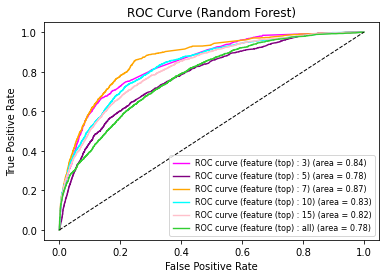

In [167]:
fpr_rf1, tpr_rf1, roc_auc_rf1 = roc_calculation(prediction_rf1) 
fpr_rf2, tpr_rf2, roc_auc_rf2 = roc_calculation(prediction_rf2) 
fpr_rf3, tpr_rf3, roc_auc_rf3 = roc_calculation(prediction_rf3)
fpr_rf4, tpr_rf4, roc_auc_rf4 = roc_calculation(prediction_rf4)
fpr_rf5, tpr_rf5, roc_auc_rf5 = roc_calculation(prediction_rf5)
fpr_rf6, tpr_rf6, roc_auc_rf6 = roc_calculation(prediction_rf6)

plt.figure(figsize=(6, 4))
plt.plot(fpr_rf2, tpr_rf2, color='magenta', lw=1.4, label=f'ROC curve (feature (top) : 3) (area = {roc_auc_rf2:.2f})')
plt.plot(fpr_rf1, tpr_rf1, color='purple', lw=1.4, label=f'ROC curve (feature (top) : 5) (area = {roc_auc_rf1:.2f})')
plt.plot(fpr_rf3, tpr_rf3, color='orange', lw=1.4, label=f'ROC curve (feature (top) : 7) (area = {roc_auc_rf3:.2f})')
plt.plot(fpr_rf4, tpr_rf4, color='cyan', lw=1.4, label=f'ROC curve (feature (top) : 10) (area = {roc_auc_rf4:.2f})')
plt.plot(fpr_rf5, tpr_rf5, color='pink', lw=1.4, label=f'ROC curve (feature (top) : 15) (area = {roc_auc_rf5:.2f})')
plt.plot(fpr_rf6, tpr_rf6, color='limegreen', lw=1.4, label=f'ROC curve (feature (top) : all) (area = {roc_auc_rf6:.2f})')

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend(loc='lower right', fontsize = 8)
plt.show()

# Confusion Matrix for Random Forest

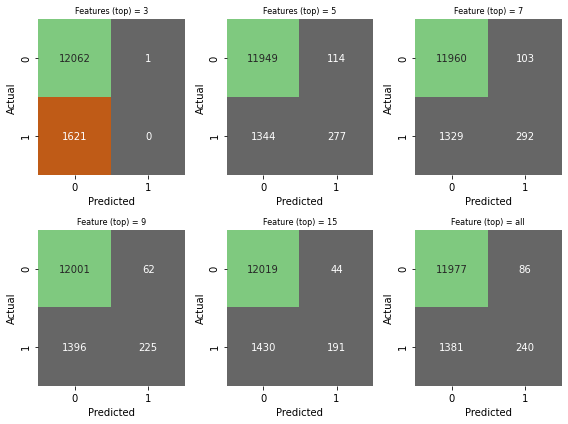

In [168]:
cm_rf1 = confusion_mat(prediction_rf1)
cm_rf2 = confusion_mat(prediction_rf2)
cm_rf3 = confusion_mat(prediction_rf3)
cm_rf4 = confusion_mat(prediction_rf4)
cm_rf5 = confusion_mat(prediction_rf5)
cm_rf6 = confusion_mat(prediction_rf6)

fig, axes = plt.subplots(2, 3, figsize=(8, 6))

sns.heatmap(cm_rf1, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 0], cbar = False)
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('Features (top) = 3', fontsize = 8)

sns.heatmap(cm_rf2, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 1], cbar = False)
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_title('Features (top) = 5', fontsize = 8)

sns.heatmap(cm_rf3, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 2], cbar = False)
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Actual')
axes[0, 2].set_title('Feature (top) = 7', fontsize = 8)

sns.heatmap(cm_rf4, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 0], cbar = False)
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Feature (top) = 9', fontsize = 8)

sns.heatmap(cm_rf5, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 1], cbar = False)
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title('Feature (top) = 15', fontsize = 8)

sns.heatmap(cm_rf6, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 2], cbar = False)
axes[1, 2].set_xlabel('Predicted')
axes[1, 2].set_ylabel('Actual')
axes[1, 2].set_title('Feature (top) = all', fontsize = 8)

plt.tight_layout()
plt.show()

# Decision Tree (LR feature selection)

In [198]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'y', maxBins = 8000)
model_dt = dt.fit(train_data)
prediction_dt6 = model_dt.transform(test_data)

# ROC curve for Decision Tree

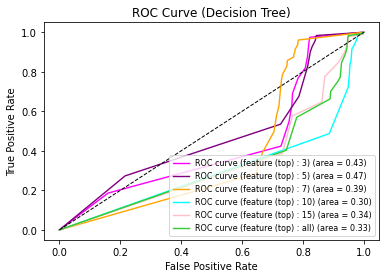

In [200]:
fpr_dt1, tpr_dt1, roc_auc_dt1 = roc_calculation(prediction_dt1) 
fpr_dt2, tpr_dt2, roc_auc_dt2 = roc_calculation(prediction_dt2) 
fpr_dt3, tpr_dt3, roc_auc_dt3 = roc_calculation(prediction_dt3)
fpr_dt4, tpr_dt4, roc_auc_dt4 = roc_calculation(prediction_dt4)
fpr_dt5, tpr_dt5, roc_auc_dt5 = roc_calculation(prediction_dt5)
fpr_dt6, tpr_dt6, roc_auc_dt6 = roc_calculation(prediction_dt6)

plt.figure(figsize=(6, 4))
plt.plot(fpr_dt2, tpr_dt2, color='magenta', lw=1.4, label=f'ROC curve (feature (top) : 3) (area = {roc_auc_dt2:.2f})')
plt.plot(fpr_dt1, tpr_dt1, color='purple', lw=1.4, label=f'ROC curve (feature (top) : 5) (area = {roc_auc_dt1:.2f})')
plt.plot(fpr_dt3, tpr_dt3, color='orange', lw=1.4, label=f'ROC curve (feature (top) : 7) (area = {roc_auc_dt3:.2f})')
plt.plot(fpr_dt4, tpr_dt4, color='cyan', lw=1.4, label=f'ROC curve (feature (top) : 10) (area = {roc_auc_dt4:.2f})')
plt.plot(fpr_dt5, tpr_dt5, color='pink', lw=1.4, label=f'ROC curve (feature (top) : 15) (area = {roc_auc_dt5:.2f})')
plt.plot(fpr_dt6, tpr_dt6, color='limegreen', lw=1.4, label=f'ROC curve (feature (top) : all) (area = {roc_auc_dt6:.2f})')

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Decision Tree)')
plt.legend(loc='lower right', fontsize = 8)
plt.show()

# Confusion Matrix for Decision Matrix

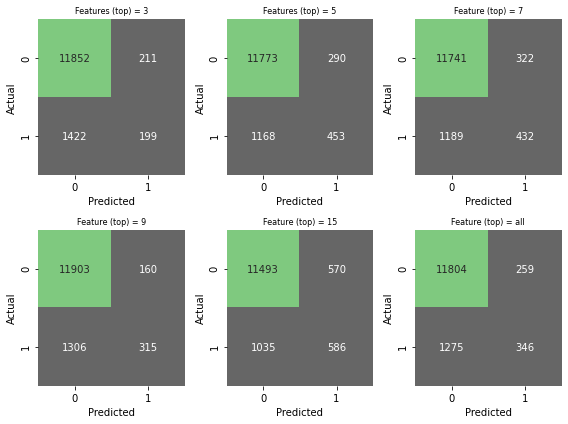

In [201]:
cm_dt1 = confusion_mat(prediction_dt1)
cm_dt2 = confusion_mat(prediction_dt2)
cm_dt3 = confusion_mat(prediction_dt3)
cm_dt4 = confusion_mat(prediction_dt4)
cm_dt5 = confusion_mat(prediction_dt5)
cm_dt6 = confusion_mat(prediction_dt6)

fig, axes = plt.subplots(2, 3, figsize=(8, 6))

sns.heatmap(cm_dt1, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 0], cbar = False)
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('Features (top) = 3', fontsize = 8)

sns.heatmap(cm_dt2, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 1], cbar = False)
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_title('Features (top) = 5', fontsize = 8)

sns.heatmap(cm_dt3, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 2], cbar = False)
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Actual')
axes[0, 2].set_title('Feature (top) = 7', fontsize = 8)

sns.heatmap(cm_dt4, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 0], cbar = False)
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Feature (top) = 9', fontsize = 8)

sns.heatmap(cm_dt5, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 1], cbar = False)
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title('Feature (top) = 15', fontsize = 8)

sns.heatmap(cm_dt6, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 2], cbar = False)
axes[1, 2].set_xlabel('Predicted')
axes[1, 2].set_ylabel('Actual')
axes[1, 2].set_title('Feature (top) = all', fontsize = 8)

plt.tight_layout()
plt.show()

# Gradient Boosting (LR feature selection)

In [233]:
gb = GBTClassifier(featuresCol = 'features', labelCol = 'y', maxBins = 8000)
gb_model = gb.fit(train_data)
prediction_gb6 = gb_model.transform(test_data)

# ROC curve for Gradient Boosting

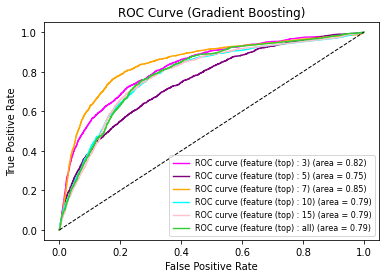

In [235]:
fpr_gb1, tpr_gb1, roc_auc_gb1 = roc_calculation(prediction_gb1) 
fpr_gb2, tpr_gb2, roc_auc_gb2 = roc_calculation(prediction_gb2) 
fpr_gb3, tpr_gb3, roc_auc_gb3 = roc_calculation(prediction_gb3)
fpr_gb4, tpr_gb4, roc_auc_gb4 = roc_calculation(prediction_gb4)
fpr_gb5, tpr_gb5, roc_auc_gb5 = roc_calculation(prediction_gb5)
fpr_gb6, tpr_gb6, roc_auc_gb6 = roc_calculation(prediction_gb6)

plt.figure(figsize=(6, 4))
plt.plot(fpr_gb2, tpr_gb2, color='magenta', lw=1.4, label=f'ROC curve (feature (top) : 3) (area = {roc_auc_gb2:.2f})')
plt.plot(fpr_gb1, tpr_gb1, color='purple', lw=1.4, label=f'ROC curve (feature (top) : 5) (area = {roc_auc_gb1:.2f})')
plt.plot(fpr_gb3, tpr_gb3, color='orange', lw=1.4, label=f'ROC curve (feature (top) : 7) (area = {roc_auc_gb3:.2f})')
plt.plot(fpr_gb4, tpr_gb4, color='cyan', lw=1.4, label=f'ROC curve (feature (top) : 10) (area = {roc_auc_gb4:.2f})')
plt.plot(fpr_gb5, tpr_gb5, color='pink', lw=1.4, label=f'ROC curve (feature (top) : 15) (area = {roc_auc_gb5:.2f})')
plt.plot(fpr_gb6, tpr_gb6, color='limegreen', lw=1.4, label=f'ROC curve (feature (top) : all) (area = {roc_auc_gb6:.2f})')

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Gradient Boosting)')
plt.legend(loc='lower right', fontsize = 8)
plt.show()

# Confusion Matrix for Gradient Boosting

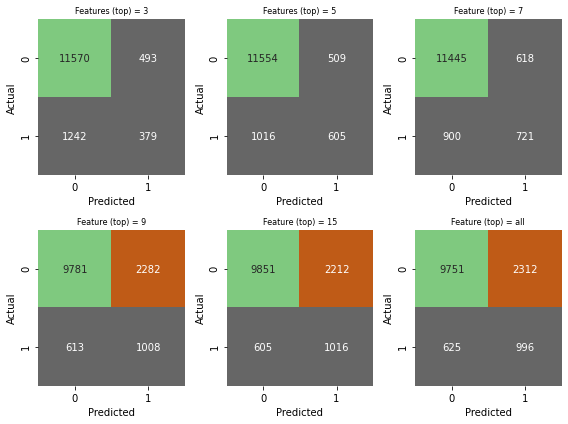

In [236]:
cm_gb1 = confusion_mat(prediction_gb1)
cm_gb2 = confusion_mat(prediction_gb2)
cm_gb3 = confusion_mat(prediction_gb3)
cm_gb4 = confusion_mat(prediction_gb4)
cm_gb5 = confusion_mat(prediction_gb5)
cm_gb6 = confusion_mat(prediction_gb6)

fig, axes = plt.subplots(2, 3, figsize=(8, 6))

sns.heatmap(cm_gb1, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 0], cbar = False)
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('Features (top) = 3', fontsize = 8)

sns.heatmap(cm_gb2, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 1], cbar = False)
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_title('Features (top) = 5', fontsize = 8)

sns.heatmap(cm_gb3, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0, 2], cbar = False)
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Actual')
axes[0, 2].set_title('Feature (top) = 7', fontsize = 8)

sns.heatmap(cm_gb4, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 0], cbar = False)
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Feature (top) = 9', fontsize = 8)

sns.heatmap(cm_gb5, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 1], cbar = False)
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title('Feature (top) = 15', fontsize = 8)

sns.heatmap(cm_gb6, annot=True, fmt='d', cmap='Accent_r', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1, 2], cbar = False)
axes[1, 2].set_xlabel('Predicted')
axes[1, 2].set_ylabel('Actual')
axes[1, 2].set_title('Feature (top) = all', fontsize = 8)

plt.tight_layout()
plt.show()